In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib
import matplotlib.pyplot as plt
import math


In [2]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [3]:
def regression_through_origin_with_correlation(x, y):
    """
    Calculate the slope of the regression line that goes through the origin
    for the given data points (x, y) and return the correlation coefficient.
    
    Parameters:
    x (array-like): Array of predictor values.
    y (array-like): Array of response values.
    
    Returns:
    tuple: The slope of the regression line through the origin and the correlation coefficient.
    """
    # Reshape x to be a 2D array with one column (required by lstsq)
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Use lstsq to fit a line through the origin
    m, _, _, _ = np.linalg.lstsq(x_reshaped, y, rcond=None)
    
    # m contains the slope of the line through the origin
    slope = m[0]
    
    # Calculate the predicted y values using the slope
    y_pred = slope * x
    
    # Calculate the correlation coefficient
    correlation_matrix = np.corrcoef(y, y_pred)
    correlation_coefficient = correlation_matrix[0, 1]
    
    return correlation_coefficient, slope

In [4]:
def normalized_slope(slope):
    return math.exp(-abs(math.log10(slope)))

def standard_metric(correlation_coef, slope):
    return normalized_slope(slope) * correlation_coef

In [8]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=[
    'model_name', 'total', 'delta', 'slope', 'correlation_coef', 'standard_metric', 
    'avg_abs_error', 'avg_abs_error_normalized', 'median_abs_error', 
    'median_abs_error_normalized', '98th_abs_error', '98th_avg_abs_error','98th_abs_error_normalized', '98th_avg_abs_error_normalized',
    'slope_98th', 'correlation_coef_98th', 'standard_metric_98th', 
])

# Iterate over each file in the directory ../model/models
for filename in os.listdir('../model/models'):
    model_name = filename[14:-3]
    print(model_name)

    if 'complex' in model_name or not filename.endswith('.pt'):
        continue

    x, y = model_name.split('_')
    total = float(x[:-1])
    delta = float(y[:-1])

    data_tensors = torch.load(f'../model/data/data_tensors_{model_name}.pt')
    target_tensors = torch.load(f'../model/data/target_tensors_{model_name}.pt')

    # Normalize the target tensors
    target_mean = target_tensors.mean()
    target_std = target_tensors.std()

    def denormalize(tensor):
        return tensor * target_std + target_mean

    target_tensors = (target_tensors - target_mean) / target_tensors.std()
    train_data, test_data, train_targets, test_targets = train_test_split(
        data_tensors, target_tensors, test_size=0.2, random_state=42
    )

    train_dataset = PacketCaptureDataset(train_data, train_targets)
    test_dataset = PacketCaptureDataset(test_data, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = len(train_dataset[0][0][0])
    hidden_size = 64
    output_size = 1
    model = RNNModel(input_size, hidden_size, output_size)

    num_samples = len(test_targets)

    # Load the weights from this file
    model = RNNModel(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(f'../model/models/{filename}'))
    model.eval()

    with torch.no_grad():
        test_data_tensor = torch.stack([item[0] for item in test_dataset])
        test_targets_tensor = torch.stack([item[1] for item in test_dataset])
        
        pred = model(test_data_tensor).flatten()
        pred_denorm = denormalize(pred).numpy().flatten()
        targets_denorm = denormalize(test_targets_tensor).numpy().flatten()
        
        correlation_coef, slope = regression_through_origin_with_correlation(
            pred_denorm,
            targets_denorm
        )
    
    standard_metric_value = standard_metric(correlation_coef, slope)
    print(f'Slope: {slope}, Correlation Coefficient: {correlation_coef}, Standard Metric: {standard_metric_value}')

    abs_errors = torch.abs(denormalize(pred) - denormalize(test_targets_tensor)).numpy().flatten()
    # print("abs errors")
    # print(abs_errors)
    percent_abs_errors = abs_errors / denormalize(test_targets_tensor).numpy().flatten()
    # print("percent abs errors")
    # print(percent_abs_errors)

    avg_abs_error = np.mean(abs_errors)
    avg_abs_error_normalized = np.mean(percent_abs_errors)
    median_abs_error = np.median(abs_errors)
    median_abs_error_normalized = np.median(percent_abs_errors)
    percentile_98th = np.percentile(abs_errors, 98)
    percentile_98th_average = np.mean(abs_errors[abs_errors < percentile_98th])
    percentile_98th_normalized = np.percentile(percent_abs_errors, 98)
    percentile_98th_normalized_average = np.mean(percent_abs_errors[abs_errors < percentile_98th])

    # crop the pred_denorm, targets_denorm to only include values where the error of the prediction is within the 98th percentile
    print(pred.shape)
    print(test_targets_tensor.shape)
    print(pred_denorm.shape, targets_denorm.shape, abs_errors.shape)
    pred_denorm_98th = pred_denorm[abs_errors < percentile_98th]
    targets_denorm_98th = targets_denorm[abs_errors < percentile_98th]

    slope_98th, correlation_coef_98th = regression_through_origin_with_correlation(
        pred_denorm_98th,
        targets_denorm_98th
    )

    standard_metric_value_98th = standard_metric(correlation_coef_98th, slope_98th)


    results_df = results_df.append({
        'model_name': model_name,
        'total': total,
        'delta': delta,
        'slope': slope,
        'correlation_coef': correlation_coef,
        'standard_metric': standard_metric_value,
        'avg_abs_error': avg_abs_error,
        'avg_abs_error_normalized': avg_abs_error_normalized,
        'median_abs_error': median_abs_error,
        'median_abs_error_normalized': median_abs_error_normalized,
        '98th_abs_error': percentile_98th,
        '98th_avg_abs_error': percentile_98th_average,
        '98th_abs_error_normalized': percentile_98th_normalized,
        '98th_avg_abs_error_normalized': percentile_98th_average,
        'slope_98th': slope_98th,
        'correlation_coef_98th': correlation_coef_98th,
        'standard_metric_98th': standard_metric_value_98th
    }, ignore_index=True)

    # Plot actual vs predicted values
    plt.figure()
    plt.scatter(targets_denorm, pred_denorm, label='Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.legend()
    plt.show()

    # Print standard metric
    print("Slope: "+ str(slope))
    print("Correlation Coefficient: "+ str(correlation_coef))
    print(f'Standard metric for {model_name}: {standard_metric_value}')
    print(f'Standard metric 98th percentile for {model_name}: {standard_metric_value_98th}')

# Save the results to a CSV file if needed
results_df.to_csv('model_evaluation_results.csv', index=False)

10s_1s
torch.Size([600, 10, 22])
tensor([[[1.1900e+02, 1.1376e+02, 2.5668e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.4800e+02, 1.1400e+02, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.4200e+02, 1.1400e+02, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3200e+02, 1.1400e+02, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[6.1000e+02, 4.3976e+04, 2.5724e+04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [6.4000e+01, 5.7182e+04, 1.8466e+04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.1000e+01, 6.1527e+04, 1.0987e+04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.4700e+02, 3.8830e+04, 2.8639e+04, 

TypeError: can't multiply sequence by non-int of type 'numpy.float32'

In [ ]:
# for each total time [1, 2.5, 5, 7.5, 10], get a function to compute the mean throughput for that slot by summing the products of the mean packet size and the number of packets


In [ ]:
print(results_df)

    model_name  total  delta     slope  correlation_coef  standard_metric  \
0       10s_1s   10.0   1.00  0.509318          0.539052         0.402140   
1       10s_5s   10.0   5.00  0.375001          0.049830         0.032546   
2     5s_0.01s    5.0   0.01  0.687213          0.392930         0.333860   
3     5s_0.05s    5.0   0.05  0.532609          0.328670         0.250000   
4     15s_0.2s   15.0   0.20  0.001855          0.286101         0.018630   
5   2.5s_0.05s    2.5   0.05  0.617031          0.308351         0.250021   
6     1s_0.05s    1.0   0.05  0.514534          0.399151         0.299093   
7   7.5s_0.05s    7.5   0.05  0.741725          0.457053         0.401434   
8    15s_0.05s   15.0   0.05  0.651388          0.362354         0.300805   
9   2.5s_0.01s    2.5   0.01  0.817593          0.310342         0.284351   
10     5s_0.2s    5.0   0.20  0.226137          0.222723         0.116781   
11    1s_0.01s    1.0   0.01  0.506913          0.314429         0.234086   

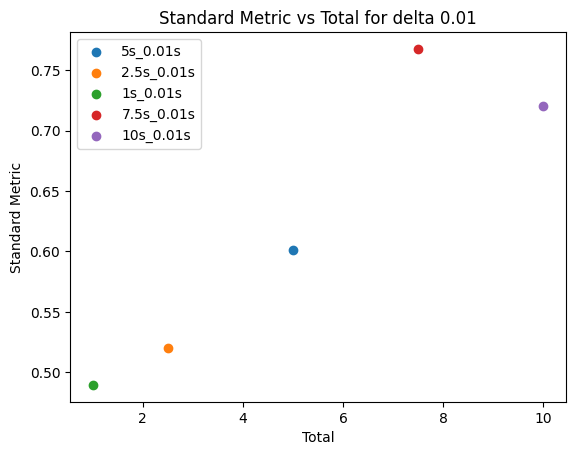

In [ ]:
# plot for each of the models with delta 0.01, plot the standard metric vs the total
plt.figure()
for index, row in results_df.iterrows():
    if row['delta'] == 0.01:
        plt.scatter(row['total'], row['standard_metric_98th'], label=row['model_name'])
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.01')
plt.legend()
plt.show()


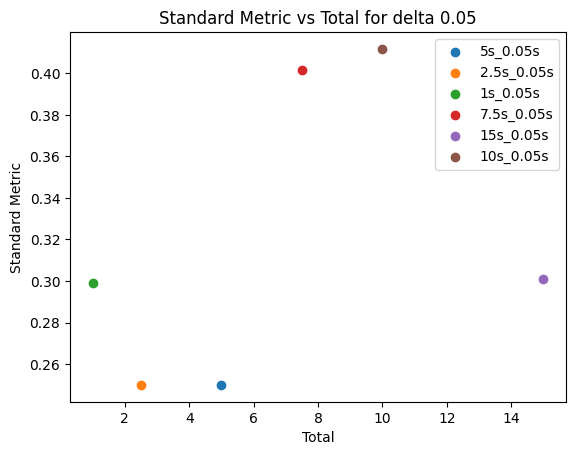

In [ ]:
# plot for each of the models with delta 0.05, plot the standard metric vs the total
plt.figure()
for index, row in results_df.iterrows():
    if row['delta'] == 0.05:
        plt.scatter(row['total'], row['standard_metric'], label=row['model_name'])
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.05')
plt.legend()


In [ ]:
# filter the dataframe to only include models with total 5
results_df_total_5 = results_df[results_df['total'] == 5]

# get the row with the maximum standard metric
max_standard_metric_row = results_df_total_5.loc[results_df_total_5['standard_metric'].idxmax()]

max_standard_metric_row

model_name                        5s_0.01s
total                                  5.0
delta                                 0.01
slope                             0.687213
correlation_coef                   0.39293
standard_metric                    0.33386
avg_abs_error                    28.681581
avg_abs_error_normalized          1.888338
median_abs_error                   1.78178
median_abs_error_normalized       0.599003
98th_abs_error                   370.96485
98th_avg_abs_error               15.088804
98th_abs_error_normalized        13.162687
98th_avg_abs_error_normalized    15.088804
slope_98th                        0.612445
correlation_coef_98th              0.74399
standard_metric_98th                0.6013
Name: 2, dtype: object

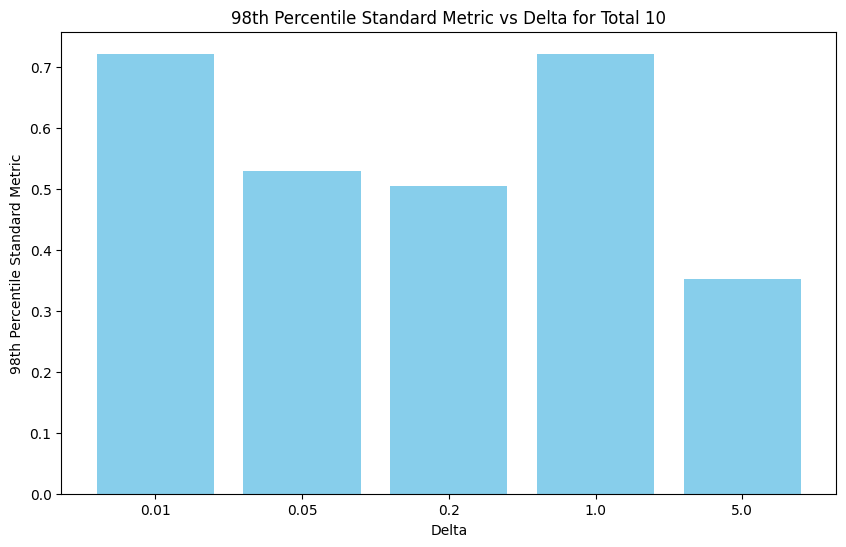

In [ ]:
# Filter and sort the DataFrame by 'delta'
subset = results_df[results_df['total'] == 10].sort_values(by='delta')

# Extract the sorted values
deltas = subset['delta'].astype(str)
standard_metrics = subset['standard_metric_98th']

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(deltas, standard_metrics, color='skyblue')

# Set the x-axis and y-axis labels and title
plt.xlabel('Delta')
plt.ylabel('98th Percentile Standard Metric')
plt.title('98th Percentile Standard Metric vs Delta for Total 10')

# Show the plot without a legend
plt.show()

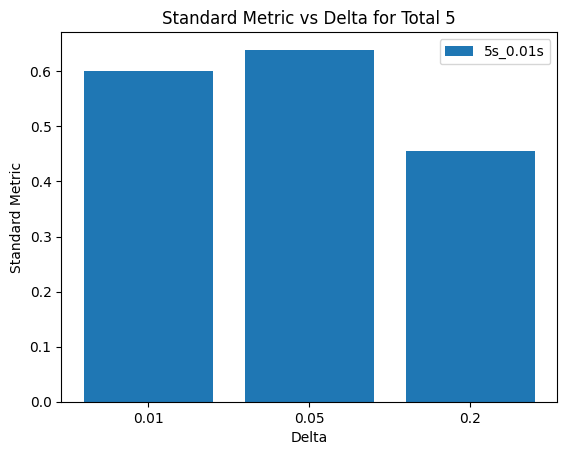

In [ ]:
# Filter and sort the DataFrame by 'delta'
subset = results_df[results_df['total'] == 5].sort_values(by='delta')

# Extract the sorted values
deltas = subset['delta'].astype(str)
standard_metrics = subset['standard_metric_98th']
model_names = subset['model_name']

# Create the bar graph
plt.figure()
plt.bar(deltas, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Delta')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Delta for Total 5')

# Add a legend
plt.legend(model_names, loc='best')

# Show the plot
plt.show()

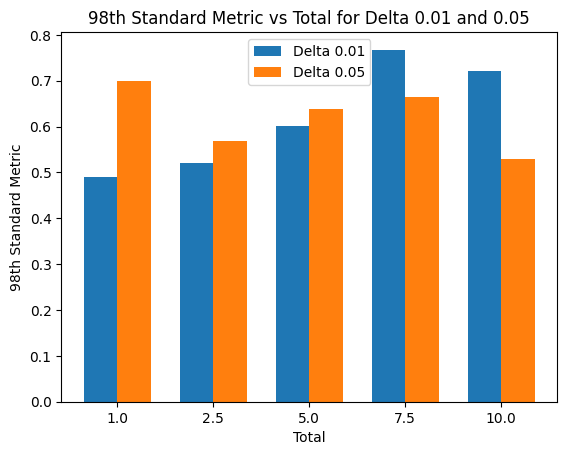

In [ ]:
# Filter the DataFrame by 'delta' values
subset_0_01 = results_df[results_df['delta'] == 0.01][['total', 'standard_metric_98th']].rename(columns={'standard_metric_98th': 'metric_0_01'})
subset_0_05 = results_df[results_df['delta'] == 0.05][['total', 'standard_metric_98th']].rename(columns={'standard_metric_98th': 'metric_0_05'})

# Merge the subsets on 'total'
merged_df = pd.merge(subset_0_01, subset_0_05, on='total').sort_values(by='total')

# Extract the sorted values
totals = merged_df['total'].astype(str)
standard_metrics_0_01 = merged_df['metric_0_01']
standard_metrics_0_05 = merged_df['metric_0_05']

# Create the bar graph
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, standard_metrics_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, standard_metrics_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('98th Standard Metric')
plt.title('98th Standard Metric vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()

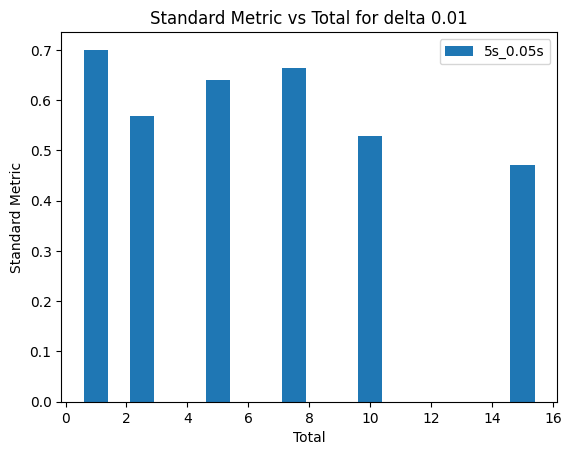

In [ ]:
plt.figure()

# Filter the DataFrame by delta 0.01
subset = results_df[results_df['delta'] == 0.05]

# Extract the total and standard metric values
totals = subset['total']
standard_metrics = subset['standard_metric_98th']
model_names = subset['model_name']

# Create the bar graph
plt.bar(totals, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.01')

# Add a legend
plt.legend(model_names, loc='best')

# Show the plot
plt.show()


In [ ]:
# get the row for 7.5s_0.01s
results_df[(results_df['total'] == 7.5) & (results_df['delta'] == 0.01)]

,model_name,total,delta,slope,correlation_coef,standard_metric,avg_abs_error,avg_abs_error_normalized,median_abs_error,median_abs_error_normalized,98th_abs_error,98th_avg_abs_error,98th_abs_error_normalized,98th_avg_abs_error_normalized,slope_98th,correlation_coef_98th,standard_metric_98th
14,7.5s_0.01s,7.5,0.01,0.952425,0.606707,0.593998,23.601318,3.3509,2.36745,0.687574,326.556734,13.130545,21.507987,13.130545,0.79974,0.845877,0.767641


### Have a model that can predict the result of a speedtest based on 7.5 seconds of data with a median error of 2.37 Mbps or a median error of 68.8%, with 98th percentile average is 13.13% This model scores 59.3% on the standard metric and a 78.8% on the 98th percentile standard metric! For the 98th percentile metric, the model has slope of 0.8 and correlation coeff of 0.846 showing that the model tends to under guess.